In [1]:
import tensorflow as tf
import scanpy as sc
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Input
from tensorflow.keras.optimizers import Adam
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping
import keras.losses
from keras import backend as K
from scipy.stats import pearsonr

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data Preparation

In [2]:
adata = sc.read_10x_mtx(
    '/Volumes/Samsung_T5/ResearchData/scanpyTutorial/data/filtered_gene_bc_matrices/hg19',  # the directory with the `.mtx` file
    var_names='gene_symbols',                      # use gene symbols for the variable names (variables-axis index)
    cache=True)

adata.var_names_make_unique()

In [3]:
data = pd.DataFrame.sparse.from_spmatrix(adata.X)
print('Working on {} cells and {} genes'.format(*data.shape))

Working on 2700 cells and 32738 genes


In [4]:
VMR = data.std() / data.mean()  # coefficient of variation: stdDev/mean (relative magnitude of std dev)
VMR[np.isinf(VMR)] = 0  # if mean is 0, we would get an infinite value --> set it to zero
potential_pred = data.columns[VMR > 0]

In [5]:
# Create covariance matrix (pd data frame),
covariance_matrix = pd.DataFrame(np.abs(np.corrcoef(data[potential_pred], rowvar= False)), # rowvar=False -> each column represents variable
    index=potential_pred,
    columns=potential_pred).fillna(0) # setting column names and fill NA with 0

covariance_matrix.shape; max(pd.Series.max(covariance_matrix)); min(pd.Series.min(covariance_matrix))


(16634, 16634)

1.0

0.0

In [6]:
data_pred_unnorm = data.loc[:,potential_pred] # UNNORMALIZED

gene_metric = (data_pred_unnorm.var()/(1+data_pred_unnorm.mean())).sort_values(ascending=False)
gene_metric = gene_metric[gene_metric > 0]

data_pred = np.log1p(data_pred_unnorm).astype(np.float32)

Int64Index([30933, 18998,  1955,  9798, 10677, 11887, 13302,  1957, 28817,
             4046,
            ...
             2720, 30779, 13061, 17008, 30774, 13078,  6383, 21922, 17003,
            26260],
           dtype='int64', length=16633)

In [47]:
# Defining target variable (y = 2 genes, x = 10 ish genes)
target_index = [30933, 21053]
target = data_pred.loc[:,[30933,21053]]
target.shape

not_target_index = gene_metric.index.drop(30933)
not_target_index = not_target_index.drop(21053)
not_target = data_pred.loc[:,not_target_index]
not_target.shape

(2700, 2)

(2700, 16632)

In [48]:
subMatrix = covariance_matrix.loc[target_index, not_target_index]
subMatrix.shape; max(pd.Series.max(subMatrix)); min(pd.Series.min(subMatrix))

(2, 16632)

0.8277694046811936

3.0313265932328734e-18

In [49]:
x = []
for i in range(2):
    indx = pd.Series.nlargest(subMatrix.iloc[i,:], 5).index
    x.extend(pd.Index.tolist(indx))
predictor_index = set(x) #keep unique only
predictor = data_pred.loc[:,predictor_index]
predictor.shape

(2700, 10)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(np.asarray(predictor), np.asarray(target), test_size=0.05)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

model = Sequential([ 
    Input(shape=( predictor.shape[1] ,)), 
    Dense(units=256, activation="relu"), 
    Dropout(rate=0.2),
    Dense(units=2, activation="softplus")
])

model.summary()
model.layers[0].get_weights()


(2565, 10) (2565, 2)
(135, 10) (135, 2)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 3,330
Trainable params: 3,330
Non-trainable params: 0
_________________________________________________________________


[array([[ 0.00080374, -0.07929569,  0.06454806, ...,  0.11583683,
         -0.04795243,  0.02432559],
        [ 0.0532383 , -0.05055743,  0.07425807, ..., -0.00536001,
         -0.05741891, -0.05356086],
        [ 0.04442482, -0.12818667, -0.00839348, ...,  0.07404262,
         -0.1322825 , -0.03149588],
        ...,
        [ 0.12368101,  0.06007451, -0.01371455, ..., -0.08803987,
         -0.0755171 , -0.0155087 ],
        [-0.12524748, -0.03614306, -0.05131401, ..., -0.08510418,
         -0.02481095,  0.00287381],
        [-0.0740115 ,  0.08886938, -0.0238781 , ..., -0.0376536 ,
          0.02975889,  0.11924502]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [51]:
def wMSE(y_true, y_pred, binary=False):
    if binary:
        weights = tf.cast(y_true>0, tf.float32)
    else:
        weights = y_true
    return tf.reduce_mean(weights*tf.square(y_true-y_pred)) 

model.compile(optimizer=Adam(lr=0.0001), loss=wMSE, metrics=["accuracy"]) # using same optimizer and loss function as DeepImpute 

history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=500, batch_size=64)
#                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1)

Epoch 1/500
41/41 [==============================] - 0s 4ms/step - loss: 8.2793 - accuracy: 0.6713 - val_loss: 4.4065 - val_accuracy: 0.8741
Epoch 2/500
41/41 [==============================] - 0s 2ms/step - loss: 4.8394 - accuracy: 0.8507 - val_loss: 2.2701 - val_accuracy: 0.9481
Epoch 3/500
41/41 [==============================] - 0s 1ms/step - loss: 2.4226 - accuracy: 0.9248 - val_loss: 1.0842 - val_accuracy: 0.9481
Epoch 4/500
41/41 [==============================] - 0s 1ms/step - loss: 1.2753 - accuracy: 0.9318 - val_loss: 0.7009 - val_accuracy: 0.9481
Epoch 5/500
41/41 [==============================] - 0s 1ms/step - loss: 0.9482 - accuracy: 0.9392 - val_loss: 0.6325 - val_accuracy: 0.9481
Epoch 6/500
41/41 [==============================] - 0s 1ms/step - loss: 0.8726 - accuracy: 0.9415 - val_loss: 0.6198 - val_accuracy: 0.9481
Epoch 7/500
41/41 [==============================] - 0s 1ms/step - loss: 0.8278 - accuracy: 0.9376 - val_loss: 0.6042 - val_accuracy: 0.9481
Epoch 8/500
4

(0.0, 1.0)

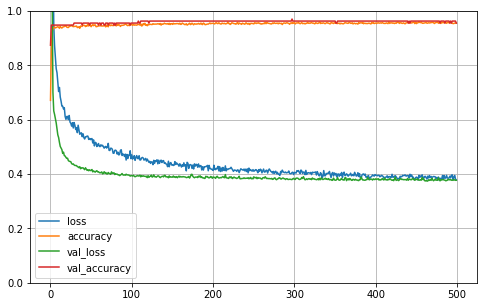

In [52]:
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
plt.show()

In [53]:
Y_test_raw = np.hstack(y_test).flatten()
Y_test_imputed = np.hstack(model.predict(X_test)).flatten()

Y_test_imputed = Y_test_imputed[Y_test_raw>0]
Y_test_raw = Y_test_raw[Y_test_raw>0]

pearsonr(Y_test_raw,Y_test_imputed)[0],

(0.9127910277571034,)